# Checkerboard Featurization and Machine Learning

In [2]:
# auto reload modules when they are changed
%load_ext autoreload
%autoreload 2

In [3]:
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from src.load_data import load_retinotopy_data

### Load Data
Load the checkerboard retinotopy data

In [10]:
data = load_retinotopy_data()
print(f"There are {len(data)} sessions in the dataset.")

There are 6 sessions in the dataset.


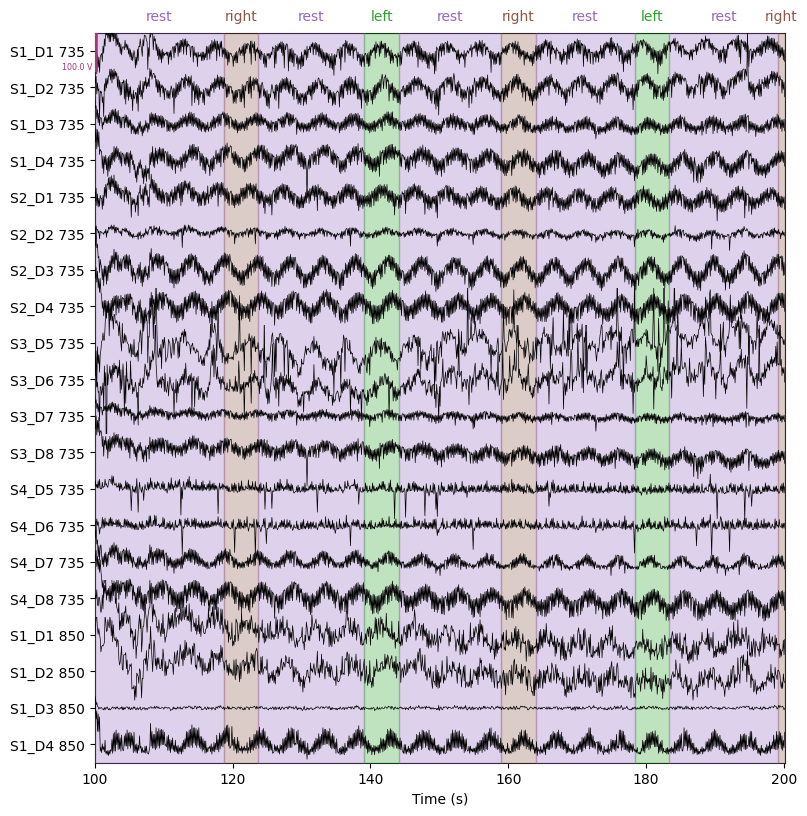

In [11]:
# Plot the first 100 seconds of the first session

data[0].plot(scalings={'fnirs_cw_amplitude': 50}, show_scrollbars=False, duration=100, start=100)
plt.show()

In [17]:
events = []
event_id = []
for data_i in data:
    (events_i, event_id_i) = mne.events_from_annotations(data_i)
    events.append(events_i)
    event_id.append(event_id_i)


Used Annotations descriptions: ['1', 'end', 'left', 'rest', 'right']
Used Annotations descriptions: ['1', 'end', 'left', 'rest', 'right']
Used Annotations descriptions: ['1', 'end', 'left', 'rest', 'right']
Used Annotations descriptions: ['1', 'end', 'left', 'rest', 'right']
Used Annotations descriptions: ['1', 'end', 'left', 'rest', 'right']
Used Annotations descriptions: ['1', 'end', 'left', 'rest', 'right']


### Postprocessing
Convert to optical density (basically take the log), then apply a bandpass filter to remove non-neural signals

In [50]:
od = [] # optical density
for data_i in data:
    od_i = mne.preprocessing.nirs.optical_density(data_i)
    od.append(od_i)
    # od.plot(n_channels=len(od.ch_names), duration=100, show_scrollbars=False, scalings={'fnirs_od': 0.1})
    # plt.show()

In [51]:
conc = []
for od_i in od:
    conc_i = mne.preprocessing.nirs.beer_lambert_law(od_i)
    conc_i = conc_i.filter(0.01, 0.1, fir_design='firwin2', verbose=False)
    conc.append(conc_i)
# conc.plot(n_channels=len(conc.ch_names), duration=100, show_scrollbars=False)
# plt.show()

/var/folders/0m/ckfdqrb51qx5mt8j0s6pz07m0000gn/T/ipykernel_89344/919740658.py:4: RuntimeWarning: filter_length (6601) is longer than the signal (5350), distortion is likely. Reduce filter length or filter a longer signal.
  conc_i = conc_i.filter(0.01, 0.1, fir_design='firwin2', verbose=False)
/var/folders/0m/ckfdqrb51qx5mt8j0s6pz07m0000gn/T/ipykernel_89344/919740658.py:4: RuntimeWarning: filter_length (6601) is longer than the signal (4664), distortion is likely. Reduce filter length or filter a longer signal.
  conc_i = conc_i.filter(0.01, 0.1, fir_design='firwin2', verbose=False)
/var/folders/0m/ckfdqrb51qx5mt8j0s6pz07m0000gn/T/ipykernel_89344/919740658.py:4: RuntimeWarning: filter_length (6601) is longer than the signal (4615), distortion is likely. Reduce filter length or filter a longer signal.
  conc_i = conc_i.filter(0.01, 0.1, fir_design='firwin2', verbose=False)
/var/folders/0m/ckfdqrb51qx5mt8j0s6pz07m0000gn/T/ipykernel_89344/919740658.py:4: RuntimeWarning: filter_length (660

In [52]:
# Turn into epochs
epochs = []

for i in range(len(conc)):
    epochs_i = mne.Epochs(
        conc[i],
        events[i],
        event_id=event_id[i],
        tmin=-6,
        tmax=20,
        reject=None,
        # reject_by_annotation=True,
        # proj=True,
        baseline=(None, 0),
        preload=True,
        detrend=None,
        verbose=False,
    )
    epochs.append(epochs_i)

epochs = mne.concatenate_epochs(epochs)

Not setting metadata
252 matching events found
Applying baseline correction (mode: mean)


/var/folders/0m/ckfdqrb51qx5mt8j0s6pz07m0000gn/T/ipykernel_89344/3653511595.py:21: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs)


## Visualize the data

In [53]:
left_channels = ["S2_D3 hbo", "S2_D4 hbo"]
right_channels = ["S3_D5 hbo", "S3_D6 hbo"]

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


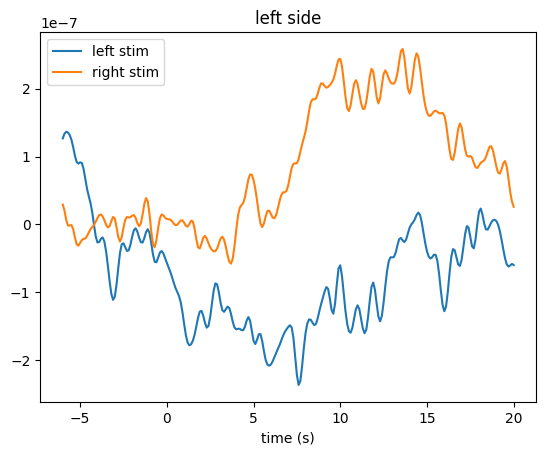

In [54]:
left_stim_left_rec = epochs["left"].pick(left_channels).average()
left_stim_right_rec = epochs["left"].pick(right_channels).average()
right_stim_left_rec = epochs["right"].pick(left_channels).average()
right_stim_right_rec = epochs["right"].pick(right_channels).average()

i = 0
t = left_stim_left_rec.times
plt.plot(t,left_stim_left_rec.data[i], label="left stim")
plt.plot(t,right_stim_left_rec.data[i], label="right stim")
plt.legend()
plt.xlabel("time (s)")
plt.title("left side")
plt.show()

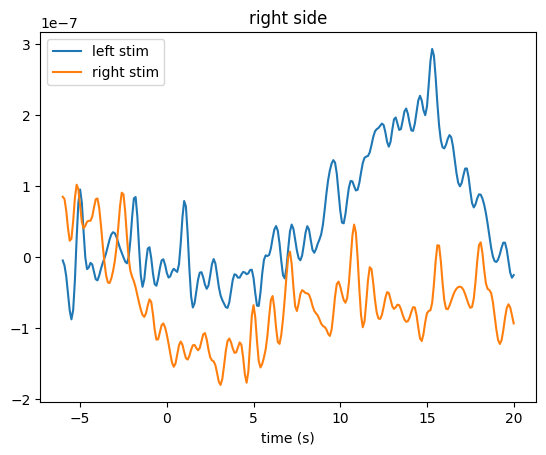

In [55]:
i = 0
plt.plot(t, left_stim_right_rec.data[i], label="left stim")
plt.plot(t, right_stim_right_rec.data[i], label="right stim")
plt.legend()
plt.xlabel("time (s)")
plt.title("right side")
plt.show()

Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


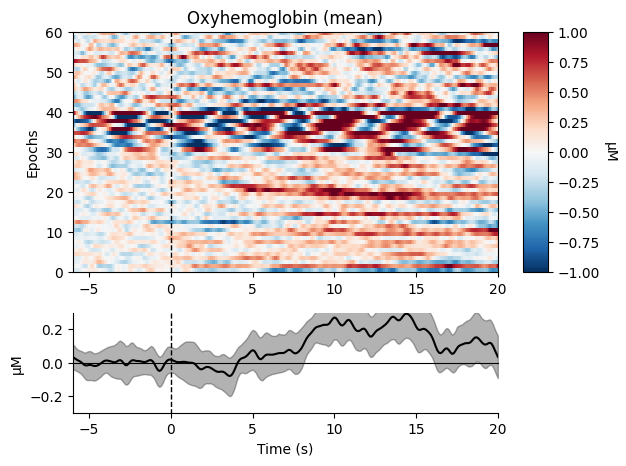

In [56]:
# plot HbO for all epochs on the left channels, with the right checkerboard

epochs["right"].pick(left_channels).plot_image(
    combine="mean",
    vmin=-1,
    vmax=1,
    ts_args=dict(ylim=dict(hbo=[-0.3, 0.3], hbr=[-0.3, 0.3])),
)
plt.show()

Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


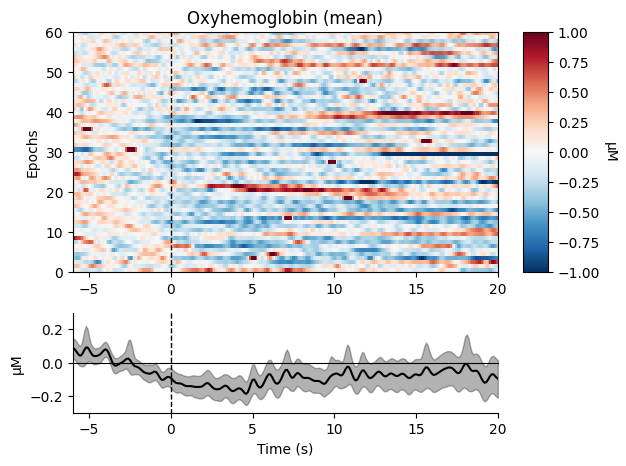

In [57]:
# plot HbO for all epochs on the right channels, with the right checkerboard

epochs["right"].pick(right_channels).plot_image(
    combine="mean",
    vmin=-1,
    vmax=1,
    ts_args=dict(ylim=dict(hbo=[-0.3, 0.3], hbr=[-0.3, 0.3])),
)
plt.show()

## Machine Learning

In [58]:
from src.ml import build_train_test

train_epochs, test_epochs = build_train_test(conc, events, event_id)

Not setting metadata
168 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)


/Users/rhotter/code/signal-classifier/src/ml.py:26: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  train_epochs = mne.concatenate_epochs(epochs[:n_train])
/Users/rhotter/code/signal-classifier/src/ml.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  test_epochs = mne.concatenate_epochs(epochs[n_train:])


In [59]:
from src.ml import featurize
train_features, train_labels = featurize(train_epochs, event_id[0])
test_features, test_labels = featurize(test_epochs, event_id[0])

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [64]:
# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1)
rf_model.fit(train_features, train_labels)

# Make predictions and evaluate
rf_pred = rf_model.predict(test_features)
rf_acc = accuracy_score(test_labels, rf_pred)

print(f'Random Forest Accuracy: {rf_acc}')


Random Forest Accuracy: 0.75
